In [1]:
!pip install -q stellargraph[demos]==1.2.1

In [2]:
!pip install -q openpyxl

In [3]:
# !pip install tensorflow-gpu

In [ ]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.2.1, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [1]:
!ls

assignment-1-part-III-for-students-2.ipynb     GCN.ipynb
dummy.xlsx				       node2vec.ipynb
file_for_network.csv			       node2vec_link_prediction.ipynb
foo3.pdf				       pathway-tf-final.xlsx
foo3.png				       pathway-tf.xlsx
foo.pdf					       tf_cascadid_colour_label_2.png
foo.png					       tf_cascadid_colour_label_3.png
GCN-2.ipynb				       tf_cascadid_colour_label.png
GCN-3 networkx for tf-pathway.ipynb	       tfc_graph_analysis.csv
GCN-4 stelllargraph.ipynb		       tfc_graph_colour.png
GCN-5 stelllargraph-Node2Vec.ipynb	       tfs.edges
gcn-for-amlsim-dataset-x009th-iteration.ipynb  tmp


In [2]:
from stellargraph import StellarGraph
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

2022-03-14 10:14:14.238937: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /ihome/crc/install/cuda-11.1.1/pytorch/1.8.1_gpu/python3.8/lib:/usr/lib64:/ihome/crc/install/cuda/11.1.1/lib64/stubs:/ihome/crc/install/cuda/11.1.1/lib64
2022-03-14 10:14:14.238981: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-03-14 10:14:14.240117: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perfo

In [3]:
import pandas as pd

In [4]:
xl = pd.ExcelFile("pathway-tf-final.xlsx")
df = xl.parse("Sheet1", header=None)
# df.columns=["pathway","tfs"]
# df=df.head()
df1=df

In [5]:
df=df1

In [6]:
df.columns = df.iloc[0]
df = df[1:]
df.columns=["pathway", "weight", "tfs"]
cols=['tfs','pathway', 'weight']
df["weight"] = pd.to_numeric(df["weight"])
df = df[cols]
df

/scratch/slurm-267709/ipykernel_24135/1201075705.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["weight"] = pd.to_numeric(df["weight"])


,tfs,pathway,weight
1,"['STAT3', 'PRDM1']",acute myeloid leukemia,0.009716
2,"['STAT3', 'PRDM1']",adipocytokine signaling pathway,0.009716
3,"['STAT3', 'PRDM1']",pancreatic cancer,0.009716
4,"['STAT3', 'PRDM1']",jak stat signaling pathway,0.014745
5,"['STAT3', 'KLF5']",acute myeloid leukemia,0.009716
...,...,...,...
1048571,"['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...",cell cycle,0.235056
1048572,"['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...",focal adhesion,0.381879
1048573,"['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...",neuroactive ligand receptor interaction,0.437467
1048574,"['SMAD4', 'TBX18', 'SNAI2', 'STAT1', 'TBX21', ...",prostate cancer,0.000002


In [7]:
df.head()

,tfs,pathway,weight
1,"['STAT3', 'PRDM1']",acute myeloid leukemia,0.009716
2,"['STAT3', 'PRDM1']",adipocytokine signaling pathway,0.009716
3,"['STAT3', 'PRDM1']",pancreatic cancer,0.009716
4,"['STAT3', 'PRDM1']",jak stat signaling pathway,0.014745
5,"['STAT3', 'KLF5']",acute myeloid leukemia,0.009716


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 1 to 1048575
Data columns (total 3 columns):
 #   Column   Non-Null Count    Dtype  
---  ------   --------------    -----  
 0   tfs      1048575 non-null  object 
 1   pathway  1048575 non-null  object 
 2   weight   1048575 non-null  float64
dtypes: float64(1), object(2)
memory usage: 24.0+ MB


In [9]:
list_1=df["tfs"].value_counts()
list_1.__len__()

10000

In [10]:
df=df.drop_duplicates(subset=['tfs','pathway'],keep='first', inplace=False)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352577 entries, 1 to 1048559
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   tfs      352577 non-null  object 
 1   pathway  352577 non-null  object 
 2   weight   352577 non-null  float64
dtypes: float64(1), object(2)
memory usage: 10.8+ MB


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 352577 entries, 1 to 1048559
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   tfs      352577 non-null  object 
 1   pathway  352577 non-null  object 
 2   weight   352577 non-null  float64
dtypes: float64(1), object(2)
memory usage: 10.8+ MB


In [13]:
df=df.drop_duplicates( keep=False)
df.shape

(352577, 3)

In [14]:
list_1=df["pathway"].value_counts()
list_1.__len__()

49

In [15]:
df.columns=['source', 'target', 'weight']

## Stellargraph

In [16]:
# cols=['source', 'target']
cols=df.columns
square_edges = df[cols]
square_edges

,source,target,weight
1,"['STAT3', 'PRDM1']",acute myeloid leukemia,0.009716
2,"['STAT3', 'PRDM1']",adipocytokine signaling pathway,0.009716
3,"['STAT3', 'PRDM1']",pancreatic cancer,0.009716
4,"['STAT3', 'PRDM1']",jak stat signaling pathway,0.014745
5,"['STAT3', 'KLF5']",acute myeloid leukemia,0.009716
...,...,...,...
1048494,"['HMGA2', 'SOX2', 'NANOG', 'POU5F1', 'SALL4', ...",notch signaling pathway,0.137568
1048553,"['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...",vegf signaling pathway,0.027106
1048557,"['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...",circadian rhythm,0.048064
1048558,"['LEF1', 'MYC', 'SNAI1', 'NANOG', 'POU5F1', 'S...",axon guidance,0.063702


In [17]:
square = StellarGraph(edges=square_edges)
print(square.info())

StellarGraph: Undirected multigraph
 Nodes: 10049, Edges: 352577

 Node types:
  default: [10049]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [352577]
        Weights: range=[1.13e-19, 0.437467], mean=0.0922638, std=0.0879348
        Features: none


In [18]:
square_named = StellarGraph(
    edges=square_edges, #node_type_default="tfs", edge_type_default="pathway"
)
print(square_named.info())

StellarGraph: Undirected multigraph
 Nodes: 10049, Edges: 352577

 Node types:
  default: [10049]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [352577]
        Weights: range=[1.13e-19, 0.437467], mean=0.0922638, std=0.0879348
        Features: none


In [19]:
# square_named

In [20]:
# square_edges_first_second = square_edges.rename(
#     columns={"source": "tfs", "target": "pathway"}
# )
# square_edges_first_second

In [21]:
# square_first_second = StellarGraph(
#     edges=square_edges_first_second, source_column="tfs", target_column="pathway",node_type_default="tfs", edge_type_default="pathway"
# )
# print(square_first_second.info())

In [22]:

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
from stellargraph import datasets
from IPython.display import display, HTML
%matplotlib inline

In [23]:
G=square
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 10049, Edges: 352577

 Node types:
  default: [10049]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [352577]
        Weights: range=[1.13e-19, 0.437467], mean=0.0922638, std=0.0879348
        Features: none


In [24]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 35257 positive and 35257 negative edges. **


In [25]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global", keep_connected=True
)

** Sampled 31732 positive and 31732 negative edges. **


In [26]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 10049, Edges: 285588

 Node types:
  default: [10049]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [285588]
        Weights: range=[1.13e-19, 0.437467], mean=0.0915989, std=0.0880133
        Features: none


In [27]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 10049, Edges: 317320

 Node types:
  default: [10049]
    Features: none
    Edge types: default-default->default

 Edge types:
    default-default->default: [317320]
        Weights: range=[1.13e-19, 0.437467], mean=0.0919788, std=0.0880105
        Features: none


# NODE2VEC

In [28]:
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn import preprocessing

import numpy as np

from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph

from gensim.models import Word2Vec

import warnings
import collections
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt

%matplotlib inline

In [29]:
walk_length = 100  # maximum length of a random walk to use throughout this notebook

In [30]:
G = StellarGraph(
    edges=square_edges, node_type_default="tfs", edge_type_default="pathway"
)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 10049, Edges: 352577

 Node types:
  tfs: [10049]
    Features: none
    Edge types: tfs-pathway->tfs

 Edge types:
    tfs-pathway->tfs: [352577]
        Weights: range=[1.13e-19, 0.437467], mean=0.0922638, std=0.0879348
        Features: none


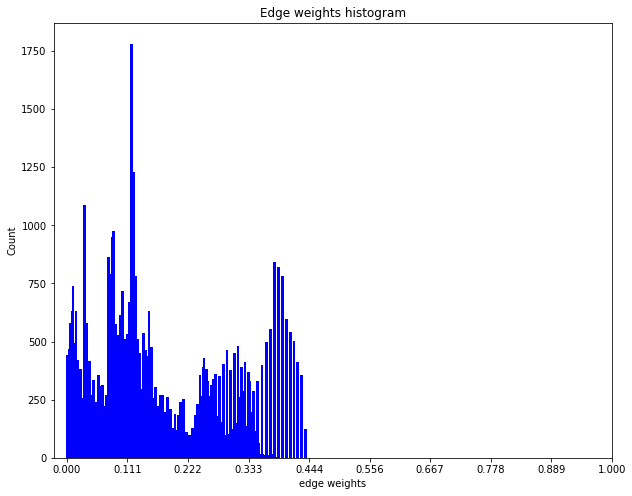

In [31]:
_, weights = G.edges(include_edge_weight=True)

wt, cnt = np.unique(weights, return_counts=True)

plt.figure(figsize=(10, 8))
plt.bar(wt, cnt, width=0.005, color="b")
plt.title("Edge weights histogram")
plt.ylabel("Count")
plt.xlabel("edge weights")
plt.xticks(np.linspace(0, 1, 10))

plt.show()

In [32]:
rw = BiasedRandomWalk(G)

In [ ]:
weighted_walks = rw.run(
    nodes=G.nodes(),  # root nodes
    length=walk_length,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    p=0.5,  # Defines (unormalised) probability, 1/p, of returning to source node
    q=2.0,  # Defines (unormalised) probability, 1/q, for moving away from source node
    weighted=True,  # for weighted random walks
    seed=42,  # random seed fixed for reproducibility
)
print("Number of random walks: {}".format(len(weighted_walks)))

In [ ]:
weighted_model = Word2Vec(
    weighted_walks, size=128, window=5, min_count=0, sg=1, workers=1, iter=1
)

In [ ]:
# The embedding vectors can be retrieved from model.wv using the node ID as key.
# E.g., for node id '19231', the embedding vector is retrieved as
emb = weighted_model.wv["19231"]
emb.shape

# Visualise Node Embeddings generated by weighted random walks

In [ ]:
# Retrieve node embeddings and corresponding subjects
node_ids = weighted_model.wv.index2word  # list of node IDs
weighted_node_embeddings = (
    weighted_model.wv.vectors
)  # numpy.ndarray of size number of nodes times embeddings dimensionality
# the gensim ordering may not match the StellarGraph one, so rearrange
node_targets = subjects.loc[node_ids].astype("category")

In [ ]:
# Apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=2, random_state=42)
weighted_node_embeddings_2d = tsne.fit_transform(weighted_node_embeddings)

In [ ]:
# draw the points
alpha = 0.7

plt.figure(figsize=(10, 8))
plt.scatter(
    weighted_node_embeddings_2d[:, 0],
    weighted_node_embeddings_2d[:, 1],
    c=node_targets.cat.codes,
    cmap="jet",
    alpha=0.7,
)
plt.show()